# Figures S5, S6, and S7
This code loads the data and produces figures S5, S6, and S7. 

In [7]:
savedate = '20251031'

In [1]:
data_folder = '' # path to data

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

## Load data

In [3]:
# Load station-level data (for mapping of cluster label to state)
string_cols = ['unique_ID', 'Station Name', 'City', 'State', 'ZIP']
poi_cols = ['no_PoI_500', 'no_Commercial_500', 'no_Education/Child_Care_500', 'no_Gas_Station_500', 
                 'no_Hotels_500', 'no_Manufacturing_500', 'no_Medical_500', 'no_Office_500', 'no_Recreation_500',
                 'no_Restaurants_and_Bars_500', 'no_Transit_500']
dtype_dict = {i:'string' for i in string_cols}
df_stations = pd.read_csv(data_folder + '20_level_stations_US_compiled_250415.zip', index_col=0,
                                         dtype=dtype_dict, usecols=string_cols + poi_cols + ['EV DC Fast Count'])

# Load BG-level data
df_bg_level = pd.read_csv(data_folder + '23_level_BG_US_imputedquantiles_20250722.zip',dtype={'GEOID':str,'STATEFP':str,'COUNTYFP':str,'BGFIPS':str},index_col=0)
df_bg_level['STATEFP'] = df_bg_level['STATEFP'].str.zfill(2)
df_bg_level['COUNTYFP'] = df_bg_level['COUNTYFP'].str.zfill(5)

## Figure S5

In [4]:
df_bg_level['perc_within_county'] = df_bg_level.groupby('COUNTYFP')['median_household_income_imputed'].rank(pct=True)
df_bg_level['perc_within_county_bunched'] = df_bg_level['perc_within_county'].apply(lambda x: np.round(x,1))

In [5]:
cols_PoIs = ['no_PoI_Commercial', 'no_PoI_Education/Child_Care', 'no_PoI_Gas_Station', 'no_PoI_Hotels', 
             'no_PoI_Manufacturing', 'no_PoI_Medical', 'no_PoI_Office', 'no_PoI_Recreation', 
             'no_PoI_Restaurants_and_Bars', 'no_PoI_Transit']
pd.DataFrame([df_bg_level[col].sum(axis=0) for col in cols_PoIs], columns=['\# Points of Interest']).astype(int).to_latex()

'\\begin{tabular}{lr}\n\\toprule\n & \\# Points of Interest \\\\\n\\midrule\n0 & 3889796 \\\\\n1 & 345317 \\\\\n2 & 159894 \\\\\n3 & 110351 \\\\\n4 & 439242 \\\\\n5 & 1564966 \\\\\n6 & 2711095 \\\\\n7 & 928866 \\\\\n8 & 1202756 \\\\\n9 & 722171 \\\\\n\\bottomrule\n\\end{tabular}\n'

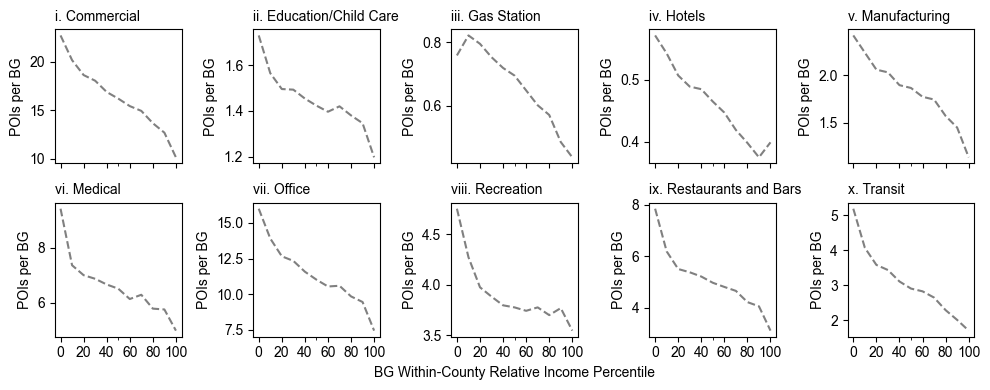

In [8]:
fig, ax = plt.subplots(2,5,figsize=(10,4), sharex=True, sharey=False)
col = 0
row = 0
counter = {0:'i', 1:'ii', 2:'iii', 3:'iv', 4:'v', 5:'vi', 6:'vii', 7:'viii', 8:'ix', 9:'x'}

for PoI_type in cols_PoIs:

    # Calculate and plot
    df= df_bg_level.groupby('perc_within_county_bunched')[PoI_type].mean()
    df.plot(linestyle='--', color='grey', ax=ax[row,col])

    # Labeling
    if col == 0:
        ax[row,col].set_ylabel('Average number of \nPoIs, normalized')
    if (row == 1) and (col == 2):
        ax[row,col].set_xlabel('BG Within-County Relative Income Percentile')
    else:
        ax[row, col].set_xlabel('')
    ax[row,col].set_title(counter[row*5+col] + '. '+PoI_type.replace('no_PoI_','').replace('_',' '),fontsize=10, loc='left')
    ax[row, col].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=[0, 20, 40, 60, 80, 100])
    ax[row, col].set_ylabel('POIs per BG')
    col += 1
    if col%5 == 0:
        col = 0
        row += 1

plt.tight_layout()
plt.savefig('Figures/figureS5_pois_relincome_'+savedate+'.pdf',bbox_inches='tight')
plt.show()

## Figure S6

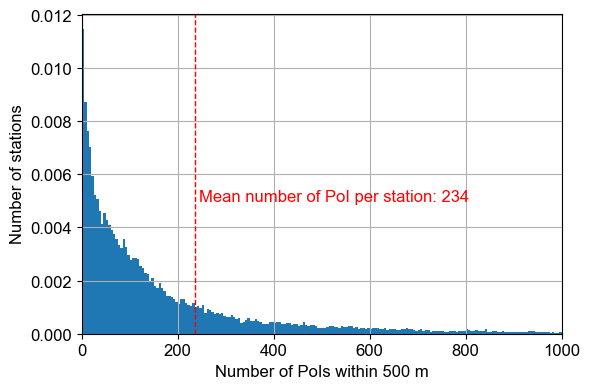

In [9]:
fig = plt.figure(dpi=100, figsize=(6, 4))

df_stations['no_PoI_500'].hist(bins=np.arange(0, df_stations['no_PoI_500'].max(), 5),density=True)

plt.axvline(df_stations['no_PoI_500'].mean(), color='r', linestyle='--', linewidth=1)
plt.annotate('Mean number of PoI per station: '+str(int(df_stations['no_PoI_500'].mean())), 
             xy=(df_stations['no_PoI_500'].mean() + 10, 0.005), color='r', fontsize=12)
plt.xlim(0, 1000)
plt.xlabel('Number of PoIs within 500 m', fontsize=12)
plt.ylabel('Number of stations', fontsize=12)
plt.xticks(fontsize=12); plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig('Figures/figureS6_pois_'+savedate+'.pdf',bbox_inches='tight')
plt.show()

## Figure S7

In [10]:
# All stations
## Calculate shares
no_stations = len(df_stations)
df_PoItypes = pd.DataFrame(index=poi_cols, columns=['no_stations', 'no_wPoI'])
for PoI_type in poi_cols:
    no_wPoI = len(df_stations.loc[df_stations[PoI_type] > 0])
    df_PoItypes.loc[PoI_type, 'no_stations'] = len(df_stations)
    df_PoItypes.loc[PoI_type, 'no_wPoI'] = no_wPoI
df_PoItypes['share_wPoI'] = df_PoItypes['no_wPoI'] / df_PoItypes['no_stations']
df_PoItypes.sort_values(by='share_wPoI', ascending=False, inplace=True)

## Rename PoI types
dict_PoI_types = {'no_PoI_500': 'With any PoI',
                  'no_Commercial_500':'With commercial PoIs',
                  'no_Education/Child_Care_500': 'With education/child care PoIs',
                  'no_Gas_Station_500': 'With gas station PoIs',
                  'no_Hotels_500':'With hotel PoIs',
                  'no_Manufacturing_500':'With manufacturing PoIs',
                  'no_Medical_500': 'With medical PoIs',
                  'no_Office_500':'With office PoIs',
                  'no_Recreation_500':'With recreation PoIs',
                  'no_Restaurants_and_Bars_500': 'With restaurant and bar PoIs',
                  'no_Transit_500': 'With transit PoIs'}
for col in df_PoItypes.index:
    if col in dict_PoI_types:
        df_PoItypes.rename(index={col: dict_PoI_types[col]}, inplace=True)
        
# Only DC stations
df_stations_DC = df_stations.loc[df_stations['EV DC Fast Count'] > 0]

## Calculate shares
no_stations = len(df_stations_DC)
df_PoItypes_DC = pd.DataFrame(index=poi_cols, columns=['no_stations', 'no_wPoI'])
for PoI_type in poi_cols:
    no_wPoI = len(df_stations_DC.loc[df_stations_DC[PoI_type] > 0])
    df_PoItypes_DC.loc[PoI_type, 'no_stations'] = len(df_stations_DC)
    df_PoItypes_DC.loc[PoI_type, 'no_wPoI'] = no_wPoI
df_PoItypes_DC['share_wPoI'] = df_PoItypes_DC['no_wPoI'] / df_PoItypes_DC['no_stations']

## Rename PoI types
for col in df_PoItypes_DC.index:
    if col in dict_PoI_types:
        df_PoItypes_DC.rename(index={col: dict_PoI_types[col]}, inplace=True)

df_PoItypes_DC = df_PoItypes_DC.loc[df_PoItypes.index]

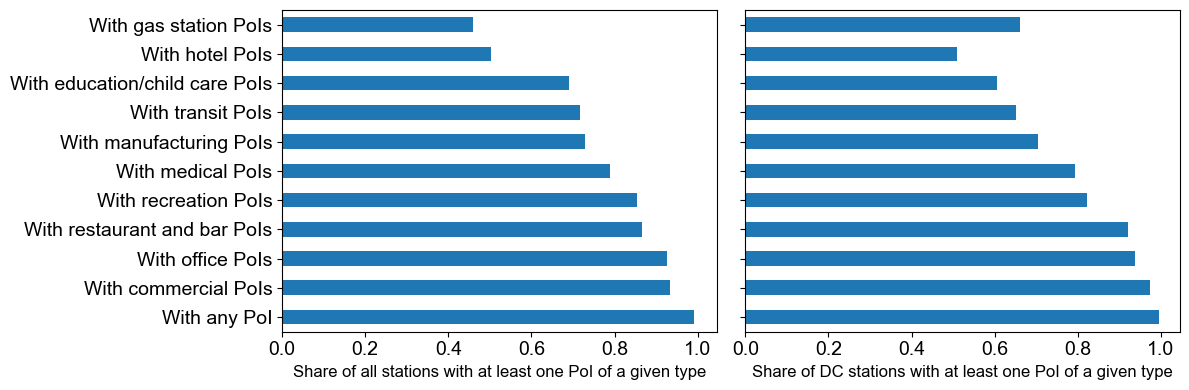

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True, sharex=True)
df_PoItypes['share_wPoI'].plot(kind='barh', ax=axes[0], fontsize=14)
df_PoItypes_DC['share_wPoI'].plot(kind='barh', ax=axes[1], fontsize=14)
axes[0].set_xlabel('Share of all stations with at least one PoI of a given type', fontsize=12)
axes[1].set_xlabel('Share of DC stations with at least one PoI of a given type', fontsize=12)
plt.tight_layout()
plt.savefig('Figures/figureS7_poi_shares_'+savedate+'.pdf', bbox_inches='tight')
plt.show()